In [9]:
from textwrap import dedent     # tap(들여쓰기)에 상관없이 쓸 수 있게.
from pprint import pprint
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import TypedDict
from typing import Literal
import os
from dotenv import load_dotenv
from langchain_chroma import Chroma
load_dotenv()

True

In [6]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
)

loader = Docx2txtLoader('./tax.docx')
temp = loader.load_and_split(text_splitter=text_splitter)

document_list = temp[0:80]
len(document_list)

80

In [7]:
from langchain_openai import OpenAIEmbeddings

embedding = OpenAIEmbeddings(model='text-embedding-3-large')

# 크로마 db 처음 생성시에만 실행

In [ ]:
from langchain_chroma import Chroma
# 크로마 db 처음 생성
vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embedding,
    collection_name='chroma-tax',
    persist_directory='./chroma-tax'
)

# 데이터 로딩

In [10]:
vector_store = Chroma(
    collection_name='chroma-tax',
    embedding_function=embedding,
    persist_directory='./chroma-tax'
)

# 리트리버 검색기 선언

In [11]:
retriever = vector_store.as_retriever(search_kwargs={'k':3})

# 포멧 선언

In [12]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# 에이전트 state 선언

In [13]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str                      # 유저 입력 쿼리문
    context: List[Document]         # 검색기로 검색된 Document 객체
    answer: str                     # 최종 답변
    grade: float                    # 리트리버 답변 품질
    retry_count: int                # 재 답변 횟수 max=4

# llm 모델선언

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(model="gpt-4o-mini")

# 유저 쿼리에 따른 리트리버 검색

In [15]:
from typing import List

def retrieve(state: AgentState) -> AgentState:
    query = state["query"]
    docs = retriever.invoke(query)
    # **state로 기존 state값을 보존 한 뒤 context만 뒤집어 씀.
    return {**state, "context": docs}       

In [16]:
def generate(state: AgentState) -> AgentState:
    response_template = """
    사용자 입력: {query}
    관련 답변: {context}
    
    위 정보를 바탕으로 사용자가 원하는 세법 관련 답변을 생성하세요.
    검색 결과의 정보를 활용하여 유용한 정보를 제공하세요.
    
    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    answer = response_chain.invoke({"query":state['query'],
                                    "context":state['context']})
    print(f"""
질문에 대한 답변: {answer}
    """)
    return {"answer":answer}

In [17]:
def rewrite(state: AgentState) -> AgentState:
    response_template = """
    당신은 질의 재작성 도우미입니다.
    아래 사용자의 질문을 RAG 검색이 잘 되는 형태로 구체화/정규화하세요.
    - 핵심 키워드 보강
    - 불필요한 일반어 제거
    - 동의어 중 도메인 표준어 사용
    - 가능한 경우 연도/조항/용어를 명시
    
    원 질문: {query}

    """
    prompt = ChatPromptTemplate.from_template(response_template)
    chain = prompt | llm | StrOutputParser()
    query = chain.invoke({"query": state["query"]})
    
    return {"query":query}
    

# 답변 품질 평가

In [18]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")
    
def grade_answer(state:AgentState):
    query = state['query']
    answer= state['answer']
    context = format_docs(state['context'])
    
    grading_system = """You are an expert grader. 
    Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
    grade_response = grading_chain.invoke({
        "question": query,
        "context": context,
        "answer": answer
    })
    
    return {"grade": grade_response.score}
    

# General 답변 품질 평가

In [19]:
from typing import Literal

def should_retry(state: AgentState) -> Literal["generate", "rewrite"]:
    print("--- 점수측정중 ---")
    print(f"Grade Score", state["grade"])
    
    if state.get('grade', 0.0) > 0.6 : return "generate"
    
    retry_count = state.get("retry_count", 0)
    if retry_count > 4: return "generate"
    return "rewrite"
    

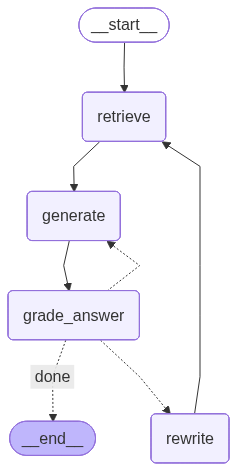

In [20]:
build = StateGraph(AgentState)

build.add_node("retrieve", retrieve)      # context 채우기
build.add_node("generate", generate)      # 답변 생성
build.add_node("grade_answer", grade_answer)  # 0~1
build.add_node("rewrite", rewrite)        # 질의 재작성(+retry_count 증가)

build.add_edge(START, "retrieve")
build.add_edge("retrieve", "generate")
build.add_edge("generate", "grade_answer")

build.add_conditional_edges("grade_answer", should_retry, {
    "done": END,
    "rewrite": "rewrite",
    "generate": "generate"  # 원한다면 '점수 충분'을 generate 재생성으로도 연결 가능
})

build.add_edge("rewrite", "retrieve")

graph = build.compile()

display(Image(graph.get_graph().draw_mermaid_png()))
